# Матрично-векторное дифференцирование. Практика

Данный семинар освещает следующие темы:
1. [Численное приближение производных](#Численное-приближение-производных)
2. [Автоматическое дифференцирование в библиотеке Jax](#Автоматическое-дифференцирование-в-библиотеке-Jax)
3. [Граф вычислений в библиотеке Pytorch](#Граф-вычислений-в-библиотеке-Pytorch)

Для написания кода потребуются следующие библиотеки:

[numpy](https://numpy.org/), [jax](https://jax.readthedocs.io/en/latest/installation.html), [pytorch >2.0](https://pytorch.org/), [autograd](https://github.com/HIPS/autograd), [matplotlib](https://matplotlib.org/)

Отдельная проблема - установка jax на windows, попробуйте https://github.com/cloudhan/jax-windows-builder

In [1]:
import numpy as np
from tqdm import tqdm
# import jax
# import jax.numpy as jnp
import autograd
import autograd.numpy as anp
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 10, 5
# plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

## Численное приближение производных

Пусть $f: \mathbb{R}^d \rightarrow \mathbb{R}$ функция векторного аргумента. Из мат. анализа, мы понимаем, как найти *частную производную* (ч.п.)
$$\frac{\partial f(\dots, x_k, \dots)}{\partial x_k} = \lim\limits_{\Delta x \rightarrow 0} \frac{f(\dots, x_k + \Delta x, \dots) - f(\dots, x_k, \dots)}{\Delta x_k}$$
и составить из ч.п. *градиент*
$$\nabla f = \left\{\frac{\partial f}{\partial x_i}\right\}_{i=1}^d,$$
прогуляться в какое-то направление $\mathbf{e}$ с этой производной
$$\frac{\partial f}{\partial \mathbf{e}} = \sum\limits_{i=1}^d \frac{\partial f}{\partial x_i} \mathbf{e}_i = \langle \nabla f, \mathbf{e} \rangle$$
а потом и до матрицы *гессиана* не далеко
$$\nabla^2 f = \left[\frac{\partial^2 f}{\partial x_i \partial x_j}\right]_{i, j = 1}^{d, d}$$
~~Дальше запускаем GD/метод Ньютона и всё работает...~~

Но как реализовать вычисление всех этих чудес?

**В качестве примеров будем использовать следующие три функции:**
\begin{gather}
f_1(x, y) = x^2 + y^2 \\
f_2(x, y) = \sin(x^2)e^{-\frac{x^2 + y^2}{5}} \\
f_3(x, y) = \begin{cases}
             \frac{x^2 y}{x^2 + y^2}, & (x, y) \neq (0, 0)\\
             0, & (x, y) = (0, 0)
            \end{cases}\\
f_4(x, y) = \sqrt[3]{x^3 + y^3}
\end{gather}

Про **autograd** более подробно прочитать в презентации здесь -  [CSC321](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf).

В целом, для первой части семинара нам понадобится только вычисление градиента из этой библиотеки, а затем мы перейдём к ``pytorch`` и ``jax`` со схожими принципами построения автоматического дифференцирования.

Библиотека ``autograd`` работает с функциями от *numpy*-массивов и строит вычисление по следующему принципу: при вычислении функции (любой промежуточной в графе вычисления) библиотека обёртывает функцию в "коробку" для генерации полного графа вычислений

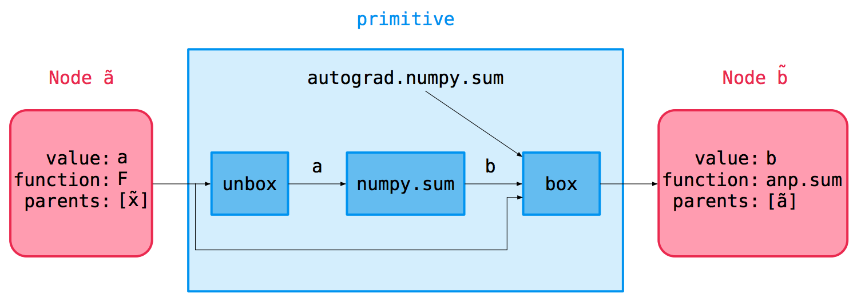

Поэтому стоит аккуратнее отнестить к заданию функции, от которой мы собираемся получить градиент:

- использовать специальные математические функции из самой библиотеки ``autograd`` (``import autograd.numpy as anp``)
- при умножении векторов/матриц также использовать операции либо чистого ``python`` (``@``),  либо также из библиотеки

В примере ниже, первая функция, написанная на чистом ``numpy`` не подойдёт для подсчёта градиента (метод grad() из библиотеки) с помощью этой библиотеки по многим причинам:
- основная - любую специальную мат. функцию надо брать из ``autograd.numpy``;
- само по себе применение ``.dot()`` из ``numpy`` безобидно (можно проверить, убрав mean), т.к. результатом операции будет *numpy.array* из одного float. Но стоит это иметь в виду, если это не последняя операция
- поскольку при добавлении ``mean()`` используется промежуточный подсчёт суммы перед делением (т.е. происходит подсчёт двух операций), что требует от ``autograd`` типа *ArrayBox* для аргумента (см. последнюю функцию)

In [3]:
W = np.array([[1.5, 0],
              [0, 1.]
             ])
w = np.array([1.5, 0])

def logistic(x: np.ndarray):
    return 1./(1 + np.exp(-np.dot(x, W).mean()))

def logistic_1(x: np.ndarray):
    return 1./(1 + anp.exp(-(x @ W).mean()))

def logistic2(x: np.ndarray):
    print(type(x@W))
    return 1./(1 + anp.exp(-anp.mean(x@W)))

grad_example = autograd.grad(logistic2)
print(grad_example(np.zeros(2)))

<class 'autograd.numpy.numpy_boxes.ArrayBox'>
[0.1875 0.125 ]


Для понимания того, как вычисляются сами производные в библиотеках, использующих концепцию ``autodiff``, важно осознать, что они:
- не используют в явном виде разностные приближения (поскольку *forward pass* может быть тяжёлым)
- опираются на процедуру подсчёта функций/их градиентов, а не дифференциируют символьно


**Вместо этого,** , библиотеки используют вычисленные заранее произведения **vector-Jacobian** (коснёмся их ещё раз уже в pytorch) для  математических функций:

Для вектор-функции $\mathbf{y}=f(\mathbf{x})$, где
$\mathbf{x}=\langle x_1,\dots,x_n\rangle$ и
$\mathbf{y}=\langle \mathbf{y}_1,\dots,\mathbf{y}_m\rangle$, производная
$\mathbf{y}$ по $\mathbf{x}$ задаётся матрицей Якоби:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial \mathbf{y}_{1}}{\partial \mathbf{x}_{1}} & \cdots & \frac{\partial \mathbf{y}_{1}}{\partial \mathbf{x}_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial \mathbf{y}_{m}}{\partial \mathbf{x}_{1}} & \cdots & \frac{\partial \mathbf{y}_{m}}{\partial \mathbf{x}_{n}}
      \end{array}\right)\end{align}

Тогда вектор строка производной для конкретного вектора $\mathbf{\overline{x}}$ получается умножением $\mathbf{\overline{x}} = \mathbf{\overline{y}}^T \mathbf{J}$

Но матрицу Якоби не вычисляют при формировании графа вычисления. Используется именно это произведение. Продемострируем, например, для функции $\mathbf{y} = g(\mathbf{x}) = \exp(\mathbf{x})$.

Функция вычисления градиента *принимает* градиент с предыдущего узла $\mathbf{\overline{y}} = \mathbf{g}$, значение выхода $\mathbf{y} = \mathbf{ans}$ и входных аргументов  $\mathbf{x}$ и *выдаёт* входной градиент $\mathbf{\overline{x}}$.
Примеры из библиотеки:

```
defvjp(exp, lambda g, ans, x: ans * g)
defvjp(log, lambda g, ans, x: g / x)
defvjp(multiply, lambda g, ans, x, y: y * g,
                 lambda g, ans, x, y: x * g)
```

Выше использованы *лямбда-функции* - это термин из теории алгоритмов и функционального программирования. В ``python`` частично реализован аппарат ФП за счёт этих функций - они позволяют задать безымянные функции (в интерпретаторе можно вызвать как анонимную функцию) без внутренних переменных (что позволяет меньше использовать память и стэк, например.

Для больших примеров использования см., например, https://realpython.com/python-lambda/

In [4]:
def f1(x: np.ndarray):
    return x.T @ x

def f2(x: np.ndarray):
    return anp.sin(x[0]**2) * anp.exp(-x.T @ x/5)

def f3(x: np.ndarray):
    norm2 = x.T @ x
    if norm2 == 0.:
        return 0.
    else:
        return x[0] * x[1]**2/ (x[0]**2 + x[1]**4)

def f4(x: np.ndarray):
    return (x[0]**3 + x[1]**3)**(1/3)

/var/folders/k0/syy814793fbbtjb2bkytslxw0000gn/T/ipykernel_28719/263624279.py:15: RuntimeWarning: invalid value encountered in double_scalars
  return (x[0]**3 + x[1]**3)**(1/3)


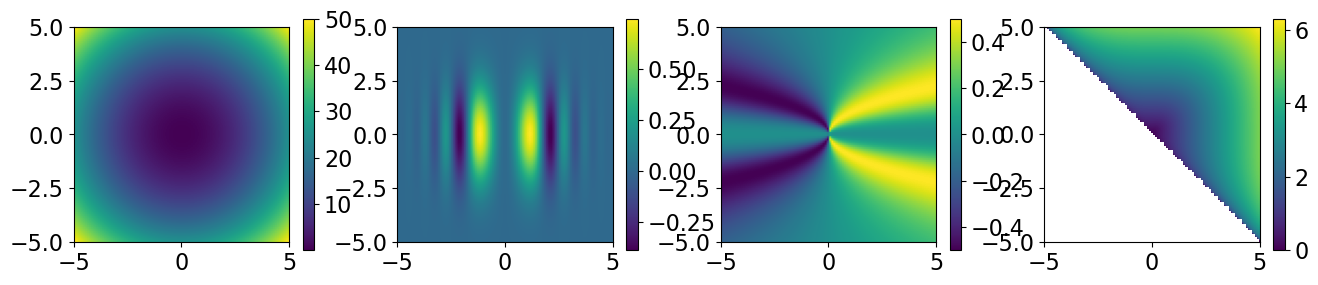

In [5]:
_x = np.linspace(-5, 5, 100)
_y = np.linspace(-5, 5, 100)
X_mesh, Y_mesh = np.meshgrid(_x, _y)
coordinates = np.stack([X_mesh, Y_mesh]).reshape((2, -1))
funcs = [f1, f2, f3, f4]

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for i, f in enumerate(funcs):
    img = axes[i].imshow(np.apply_along_axis(f, 0, coordinates).reshape((100, 100)), 
                     extent=(-5, 5, -5, 5), origin='lower')
    fig.colorbar(img, ax=axes[i])

(Вопрос) Что мы ожидаем от 3 и 4 функции в рамках вычислений градиента, производных по направлению?

### **(Задание 1) Напишите код для подсчёта частных производных приведённых выше функций**

Вычислим частные производные по формуле: 
\begin{equation}
\frac{\partial f}{\partial x_i} \approx \frac{f(\dots, x_i + \varepsilon, \dots) - f(\dots, x_i - \varepsilon, \dots)}{2\varepsilon}
\end{equation}

In [6]:
def dfdx_i(f: callable, 
           x: np.ndarray,
           i=0,
           eps=1e-3
          ):
    ### your code here ###

**В качестве проверки вашей реализации, посчитайте градиенты функции $f_1$ в точках (0, 0), (10, 0) и (5, 5).**

In [7]:
# grad_f1_0 = # your code here
# grad_f1_10 = # your code here
# grad_f1_5 = # your code here

***Для проверки вашего решения, например, мы воспользуемся библиотекой autograd.***

Как и jax, она может вычислять градиенты и пр. от функций векторного аргумента из библиотеки numpy. 

Поговорим об этом позже в jax (упомянули, чтобы знали и об этой, довольно популярной, библиотеке)

In [8]:
from autograd import grad 
assert np.allclose(grad_f1_0, grad(f1)(np.zeros(2)))
assert np.allclose(grad_f1_10, grad(f1)(np.array([10, 0.])))
assert np.allclose(grad_f1_5, grad(f1)(np.array([5, 5.])))

Размялись... Теперь задание посерьёзнее - пусть у нас есть точный градиент функции $f_2$.

In [9]:
def true_grad_f2(x: np.ndarray):
    return np.array([np.exp(-x.T @ x/5) * (2*x[0]*np.cos(x[0]**2) - 0.4*np.sin(x[0]**2)*x[0]), 
                     -np.sin(x[0]**2) * np.exp(-x.T @ x/5) * 0.4 * x[1]
                    ])

**Посчитайте для разных eps значение норму разности численного градиента и теоретического в точке (5., 2.)**

In [10]:
grad_norms = []

_point = np.array([5, 2.]) 
eps_range = ### your code here ###
for eps in tqdm(eps_range):
    ### your code here ###


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39938.85it/s]


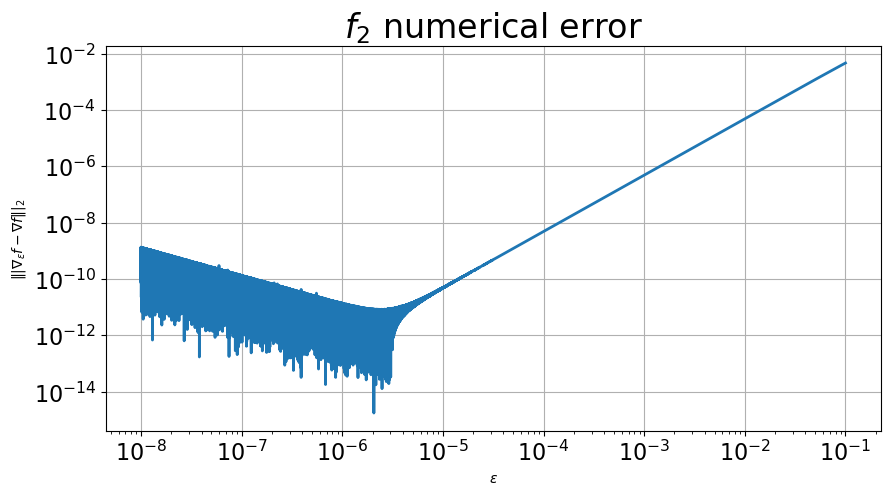

In [11]:
plt.loglog(eps_range, grad_norms)
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\|| \nabla_{\varepsilon}f - \nabla f \||_2$")
plt.title(r"$f_2$ numerical error")
plt.grid();

***Вопросы к размышлению:***
- В чём причина такого поведения?
- Из-за чего такой рост в левом конце? Разве не логичнее брать шаг всё меньше и меньше?)
- Можно ли воспроизвести такое поведение с функцией $f_1$?

#### Ответы на вопросы)

Для более подробных ответов и 4-х точечных схем см. https://www.uio.no/studier/emner/matnat/math/MAT-INF1100/h09/kompendiet/chap11.pdf

Сначала на третий - "можно ли воспроизвести?"

Можно, но довольно непрактичным образом - нелогично, как кажется, брать сильно большой шаг. 

In [12]:
def true_grad_f1(x: np.ndarray):
    return 2*x

In [13]:
grad_norms = []

_point = np.array([10, 5.]) 
eps_range = np.logspace(-4, 4, 100000)
for eps in tqdm(eps_range):
    grad_norms.append(np.linalg.norm(np.array([dfdx_i(f1, _point, i, eps=eps) for i in [0, 1]]) - true_grad_f1(_point)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 87150.00it/s]


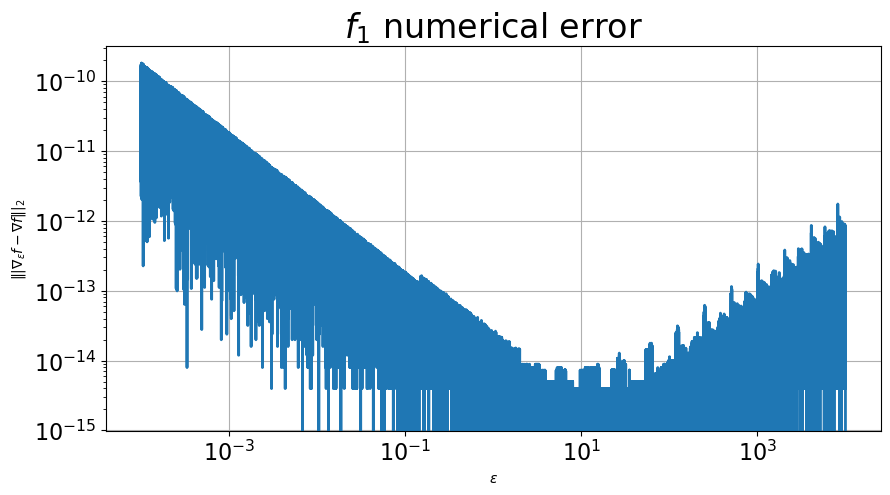

In [14]:
plt.loglog(eps_range, grad_norms)
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\|| \nabla_{\varepsilon}f - \nabla f \||_2$")
plt.title(r"$f_1$ numerical error")
plt.grid();

**А в чём первопричина такого поведения?**

Рассмотрим разложение функции с приращением:
\begin{gather}
f(\mathbf{x} + \varepsilon \mathbf{e}) = f(\mathbf{x}) + \langle \nabla f(\mathbf{x}), \varepsilon \mathbf{e}\rangle + O(\varepsilon^2) \\
\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle = \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon} + O(\varepsilon)
\end{gather}

Последнее выражение является формулой для вычисления производной по направлению $\mathbf{e}$.


Давайте оценим, какое $\varepsilon$ брать для точного вычисления?

**С точки зрения пределов логичнее брать $\varepsilon$ как можно меньше. НО нас ограничивает машинная точность - float не вытянет слишком малого значения(**

Пусть $fl(x)$ - представление вещественного числа в float формате, $\varepsilon_m$ - машинная точность. Тогда верно, что
$$|fl(x) - x| \leq \varepsilon_m |x|$$
Оценим, какая возможна минимальная ошибка между float-представлением градиента и его $\varepsilon$-вычислением:
\begin{gather}
\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right)\right| = \left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle + \langle \nabla f(\mathbf{x}), \mathbf{e}\rangle -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right) + \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon} - \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right| \leq \\
\leq \underbrace{\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right|}_{\text{Не зависит от } \varepsilon} + \underbrace{\left|\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle - \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right|}_{\leq \frac{L_2}{2} \varepsilon} + \underbrace{\left|\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon} - fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right)\right|}_{\text{При делении точность не теряется, отдельно берём дробь}} \leq \\
\leq const + \frac{L_2}{2} \varepsilon + \left|\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - fl\left(f(\mathbf{x} + \varepsilon \mathbf{e})\right) - (f(\mathbf{x}) - fl\left(f(\mathbf{x})\right))}{\varepsilon}\right| \leq \\
\leq const + \frac{L_2}{2} \varepsilon + \frac{L_0 \varepsilon_m + L_0 \varepsilon_m}{\varepsilon} = const + \frac{L_2}{2} \varepsilon + \frac{2 L_0 \varepsilon_m}{\varepsilon} \rightarrow \min_{\varepsilon}
\end{gather}

В этих обозначениях, $L_2$ - ограничение значения вторых производных в окрестности для любого направления $\mathbf{e}$ (свойство гладкости функции), $L_0$ - аналогичное ограничение функции.

Из минимизации, находим оптимальное $\varepsilon$ и ограничение сверху на ошибку представления:
\begin{gather}
\frac{L_2}{2} - \frac{1}{\varepsilon^2} 2 L_0 \varepsilon_m = 0 \Rightarrow \quad \varepsilon = 2\sqrt{\frac{L_0 \varepsilon_m}{L_2}} \approx \sqrt{\varepsilon_m} \\
\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right)\right| \leq \frac{L_2}{2} 2\sqrt{\frac{L_0 \varepsilon_m}{L_2}} + \frac{2 L_0 \varepsilon_m}{2\sqrt{\frac{L_0 \varepsilon_m}{L_2}}} = \sqrt{L_0 L_2 \varepsilon_m} + \sqrt{L_0 L_2 \varepsilon_m} = 2\sqrt{L_0 L_2 \varepsilon_m}
\end{gather}

(OPTIONAL)
Мы же использовали симметричную схему, у неё меньше математическая погрешность аппроксимации. Для неё оценка следующая (шаги те же, можно показать разложением до $O(\varepsilon^3)$):
\begin{gather}
\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle = \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x} - \varepsilon \mathbf{e})}{2 \varepsilon} + O(\varepsilon^2) \\
\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x} - \varepsilon \mathbf{e})}{2 \varepsilon}\right)\right| \leq \frac{L_3}{6}\varepsilon^2 + \frac{L_0 \varepsilon_m + L_0 \varepsilon_m}{2\varepsilon} \rightarrow \min_{\varepsilon} \\
\varepsilon = \sqrt[3]{\frac{3L_0 \varepsilon_m}{L_3}} \Rightarrow \quad \left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x} - \varepsilon \mathbf{e})}{2 \varepsilon}\right)\right| \leq \sqrt[3]{L_3 L_0^2 \varepsilon_m^2}\left(\frac{\sqrt[3]{9}}{6} + \frac{\sqrt[3]{9}}{3}\right) = \frac{\sqrt[3]{9 L_3 L_0^2 \varepsilon_m^2}}{2}
\end{gather}

**Итого: Причина поведения на графике (и отличия поведения $f_1$ и $f_2$) в:**
- Зависимости погрешности аппроксимации производных от машинной точности
- Ограниченности погрешности константами Липшецевости для вторых/третьих производных и самих значений функций

### **Задание 2. Производные по направлению. Комплексное разложение**

Вообще говоря, мы умеем делать комплексные разложения. Могут ли они нам помочь? 

ДА!

\begin{gather}
f(\mathbf{x} + i\varepsilon \mathbf{e}) = f(\mathbf{x}) + \langle \nabla f(\mathbf{x}), i\varepsilon \mathbf{e}\rangle - \frac{1}{2} \langle\mathbf{e}, \nabla^2 f(\mathbf{x}) \mathbf{e}\rangle\varepsilon^2 + iO(\varepsilon^3) \\
Im(f(\mathbf{x} + i\varepsilon \mathbf{e})) = \langle \nabla f(\mathbf{x}), \mathbf{e}\rangle \varepsilon + O(\varepsilon^3) \Rightarrow \langle \nabla f(\mathbf{x}), \mathbf{e}\rangle = \frac{Im(f(\mathbf{x} + i\varepsilon \mathbf{e}))}{\varepsilon} + O(\varepsilon^2)
\end{gather}

Эта оценка не содержит разностных схем, что позволяет улучшить оценку в случае приближения $\varepsilon$ к машинной точности.
Проиллюстрируем это на примере $f_2, f_3, f_4$.

**Используя код подсчёта градиента из прошлого задания, реализуйте вычисление градиента по направлению**

In [15]:
def df_direction(f: callable, 
                 x: np.ndarray,
                 e: np.ndarray,
                 eps=1e-3
                ):
    ### your code here ###

**Сравните для разных $\varepsilon$ результаты вашей реализации и комплексного приближения (код ниже) на единичном направлении с теоретическим градиентом функции $f_2$**

Для справки: в ``python`` реализован механизм работы с комплексными числами. Для этого зарезервирована переменная мнимой единицы `1j` и у таких чисел есть атрибуты `real`, `imag`.

Библиотека `numpy`, в продолжение, позволяет оперировать комплексными векторами и вычислять от них функции (также есть и `np.real`, `np.imag`). 

In [16]:
complex_num = 3j + 4
print(complex_num.real, complex_num.imag,
      abs(complex_num))

4.0 3.0 5.0


In [17]:
def df_dir_complex(f: callable, 
                   x: np.ndarray,
                   e: np.ndarray,
                   eps=1e-3
                  ):
    return np.imag(f(x + 1j*eps*e))/eps

In [18]:
directional_diffs = []
im_directional_diffs = []

_e = np.array([1, 1.]) 
_point = np.array([5, 2.]) 
eps_range = ### your code here ###
for eps in tqdm(eps_range):
    ### your code here ###

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 31385.20it/s]


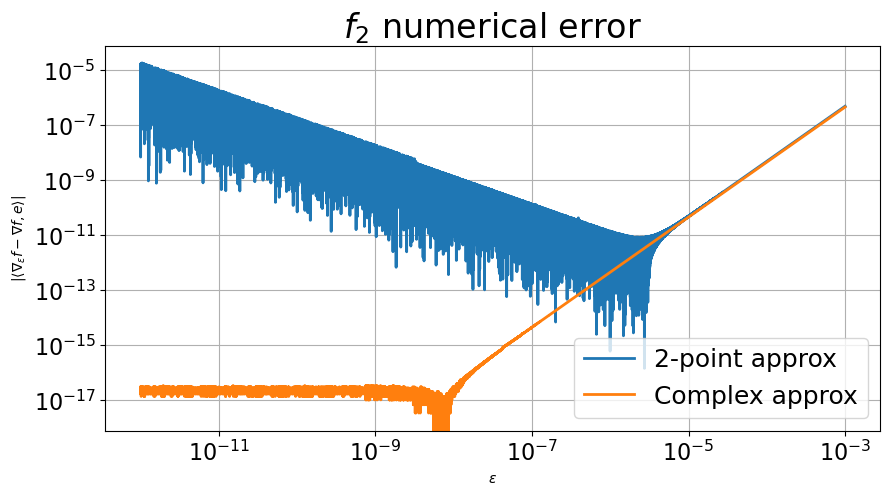

In [19]:
plt.loglog(eps_range, directional_diffs, label="2-point approx")
plt.loglog(eps_range, im_directional_diffs, label="Complex approx")
plt.legend()
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$| \langle\nabla_{\varepsilon}f - \nabla f, e\rangle|$")
plt.title(r"$f_2$ numerical error")
plt.grid();

**Вывод:**

При возможности применения комплексного представления функции данный вид аппроксимации позволяет достичь машинной точности.

Для применения в физике комплексного приближения см. https://provost.utsa.edu/undergraduate-research/journal/files/vol2/UJRSW.Roussel.Millwater.pdf

**Последний комментарий**

Давайте посмотрим на две функции, у которых существуют производные по направлениям, но они не дифференцируемы (т.к. производные не непрерывны).

Попробуем вычислить градиенты по направлению в точке (0, 0) библиотекой autograd и руками с помощью комплексного представления. 

In [20]:
autograd_f3 = grad(f3)
autograd_f4 = grad(f4)

In [21]:
_point = np.array([0, 0.]) 

Выберем 8 направлений и посмотрим, какие значения принимает комплексное приближение:

In [23]:
directions = np.array([[-1, -1.],
                       [0, -1.],
                       [-1, 0],
                       [0, 1],
                       [1, 0],
                       [1, 1],
                       [-1, 1],
                       [1, -1]
                      ]) 
print("f3 directional derivatives")
for _e in directions:
    print(f"({_e[0]}, {_e[1]}): Complex={df_dir_complex(f3, _point, _e, eps=1e-10):.3f},\
    2-points={df_direction(f3, _point, _e, eps=1e-10):.3f},\
    autograd={autograd_f3(_point).dot(_e):.3f}")

f3 directional derivatives
(-1.0, -1.0): Complex=-1.000,    2-points=0.000,    autograd=0.000
(0.0, -1.0): Complex=-0.000,    2-points=0.000,    autograd=0.000
(-1.0, 0.0): Complex=-0.000,    2-points=0.000,    autograd=0.000
(0.0, 1.0): Complex=0.000,    2-points=0.000,    autograd=0.000
(1.0, 0.0): Complex=-0.000,    2-points=0.000,    autograd=0.000
(1.0, 1.0): Complex=1.000,    2-points=0.000,    autograd=0.000
(-1.0, 1.0): Complex=-1.000,    2-points=0.000,    autograd=0.000
(1.0, -1.0): Complex=1.000,    2-points=0.000,    autograd=0.000


In [26]:
print("f4 directional derivatives")
for _e in directions:
    print(f"({_e[0]}, {_e[1]}): Complex={df_dir_complex(f4, _point, _e, eps=1e-10):.3f},\
    2-points={df_direction(f4, _point, _e, eps=1e-10):.3f},\
    autograd={autograd_f4(_point).dot(_e):.3f}")

f4 directional derivatives
(-1.0, -1.0): Complex=0.630,    2-points=nan,    autograd=nan
(0.0, -1.0): Complex=0.500,    2-points=nan,    autograd=nan
(-1.0, 0.0): Complex=0.500,    2-points=nan,    autograd=nan
(0.0, 1.0): Complex=-0.500,    2-points=nan,    autograd=nan
(1.0, 0.0): Complex=-0.500,    2-points=nan,    autograd=nan
(1.0, 1.0): Complex=-0.630,    2-points=nan,    autograd=nan
(-1.0, 1.0): Complex=0.000,    2-points=nan,    autograd=nan
(1.0, -1.0): Complex=0.000,    2-points=nan,    autograd=nan


/var/folders/k0/syy814793fbbtjb2bkytslxw0000gn/T/ipykernel_28719/263624279.py:15: RuntimeWarning: invalid value encountered in double_scalars
  return (x[0]**3 + x[1]**3)**(1/3)


**Вопрос:**

~~Что происходит?~~ 
- Почему в первом случае комплексное приближение выдаёт такие значения?
- Кто же прав во втором случае?

Ответы:

- В первом случае (как и везде при использовании комплексного приближения), мы хотим, чтобы функция была дифференцируема. Но это не так - в точке 0 данная функция не дифференцируема. Объяснение более подробное, чем словами - [stackexchange](https://math.stackexchange.com/questions/367774/show-that-a-function-has-directional-derivatives-at-a-point-but-is-not-different), [mathinsight](https://mathinsight.org/nondifferentiable_discontinuous_partial_derivatives)

- Во втором случае всё интереснее. Вообще говоря, никто не прав) По идее, частные производные у этой функции в нуле существуют, они равны 1 (см. [stackexchange](https://math.stackexchange.com/questions/673975/function-has-partial-derivatives-but-is-not-differentiable)). Комплексная аппроксимация пытается справиться с их существованием, но беда подходит с другого края - функция не дифференцируема в нуле. ~~Это поражение, с этой утратой никто не справится~~

## Автоматическое дифференцирование в библиотеке JAX

### Что такое JAX?

`Google JAX` ещё один `python` фреймворк для машинного обучения и оптимизации, позволяющий писать высокоэффективный код с использованием `GPU/TPU` с помощью [`XLA`](https://www.tensorflow.org/xla) (Accelerated Linear Algebra -- это предметно-ориентированный компилятор линейной алгебры). В фреймоврке реализован свой `autodiff`, а так же полезные возможности `compilation` и `parallelization`, о которых мы поговорим несколько позже.

Во многих случаях `API` фреймворка `JAX` совпадает с `API` фреймоврка `numpy`, поэтому чаще всего `JAX` импортируют в код через `import jax.numpy as np` (то есть с той же кличкой как и у `numpy`).

### TL;DR

Пример нахождения градиентов, якобианов и гессианов:

1. Импортировать `jax.numpy`, чтобы записывать функции на понятном для `jax` языке

In [27]:
import jax
import jax.numpy as jnp


def f2_float(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp(-x.T @ x / 5)


def f_vec(x: np.ndarray):
    """
    R^n -> R^n
    """
    return jnp.sin(x)

2. Чтобы получить градиент функции нужно воспользоваться `jax.grad()`

In [28]:
grad_f2 = jax.grad(f2_float)
print(f"grad at x = 0, y = 0: {grad_f2(np.array([0., 0.]))}")

grad at x = 0, y = 0: [0. 0.]


3. Чтобы получить якобиан нужно использовать либо `jax.jacfwd`, либо `jax.jacrev` (на функциях вида R^n -> R совпадает с градиентом).

In [29]:
jacf_f2 = jax.jacfwd(f2_float)
jacb_f2 = jax.jacrev(f2_float)
print(f"Jacobian forward pass at x = 0, y = 0: {jacf_f2(np.array([0., 0.]))}")
print(f"Jacobian backward pass at x = 0, y = 0: {jacb_f2(np.array([0., 0.]))}")

Jacobian forward pass at x = 0, y = 0: [0. 0.]
Jacobian backward pass at x = 0, y = 0: [0. 0.]


In [30]:
jac_f_vec = jax.jacfwd(f_vec)
print(f"Jacobian forward pass at x = 0, y = 0:\n{jac_f_vec(np.array([0., 0.]))}")

Jacobian forward pass at x = 0, y = 0:
[[1. 0.]
 [0. 1.]]


4. Чтобы получить Гессиан достаточно последовательно применить вычисление якобиана.

In [31]:
hesse_f_f2 = jax.jacfwd(jax.jacfwd(f2_float))
print(f"Hesse at x = 0, y = 0:\n{hesse_f_f2(np.array([0., 0.]))}")

Hesse at x = 0, y = 0:
[[2. 0.]
 [0. 0.]]


### Почему `JAX`?

1. Скорость:


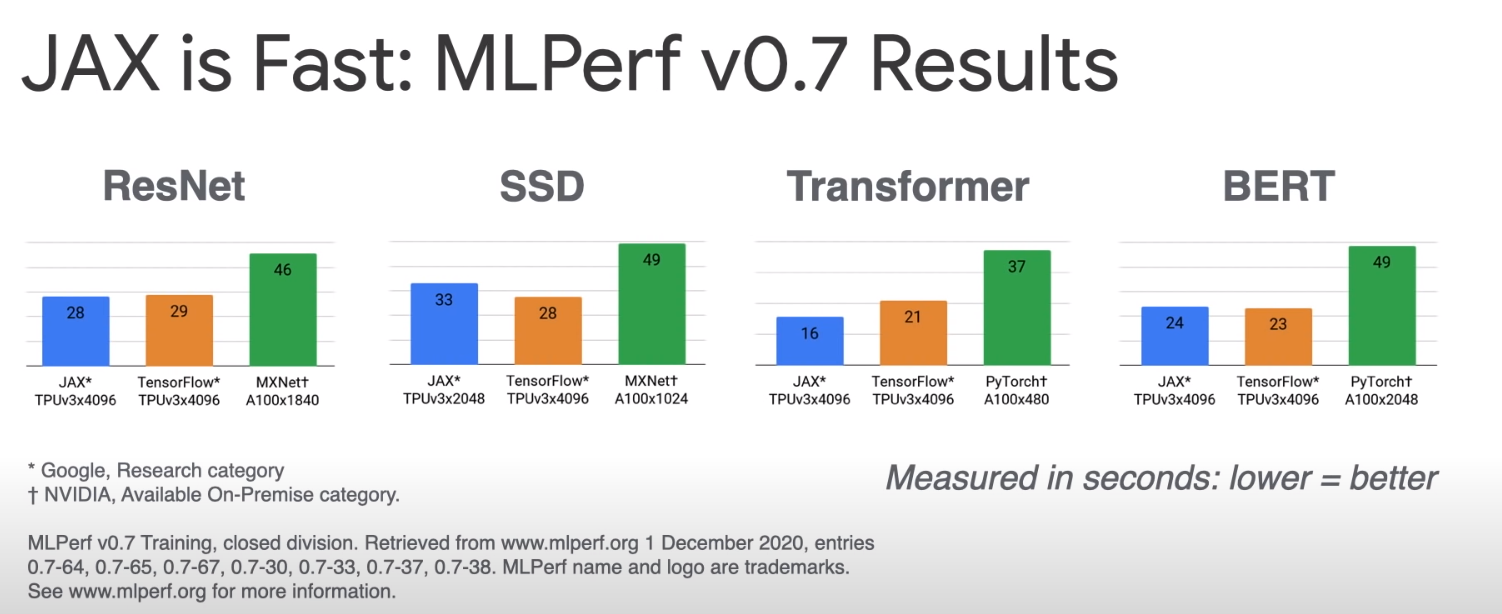

Картинка взята из [видео](https://www.youtube.com/watch?v=WdTeDXsOSj4&t=1s)

2. Схожесть `API` с `Numpy` и `Scipy`.

3. Возможность использовать `autodiff` с помощью функции `grad`.

4. Возможность векторизовать код с помощью функции `vmap` (чтобы работать без циклов).

5. Возможность компилировать часть кода с помощью функции `jit` (just-in-time compilation), что очень сильно ускоряет их работу.

6. Возможность параллелизации кода с помощью функции `pmap`, которая позволяет задействовать несколько ядер вычислительной системы.

7. `JAX` включает в себя 
    - Высокоуровневые библиотеки для глубокого обучения: `Flax, Haiku, Trax`
    - библиотеки для оптимизации: `JAXOpt, Optax`
    - библиотеки для [вероятностного программирования](https://habr.com/en/articles/244625/): `Oryx, TFP-jax, NumPyro`
    - библиотеки для работы с [графовыми нейронными сетями](https://habr.com/en/companies/vk/articles/557280/): `Jraph`
    - И многое другое...


### Как `JAX` это делает?

Не углубляясь в детали, можно сказать, что `JAX` отслеживает каждую функцию, которую написал разработчик, переписывает её в свой удобный вид, засчёт которого сразу может использовать `autodiff, vmap, pmap, jit`.

### Код

In [33]:
# Проверим платформу на которой будут производиться вычисления
from jax.lib import xla_bridge

print(f"Current computation platform is {xla_bridge.get_backend().platform}")
# JAX will preallocate 75% of the total GPU memory when the first JAX operation is run.

Current computation platform is cpu


In [34]:
# По умолчанию все вычисления производятся в float32
# Но это можно изменить

jax.config.update("jax_enable_x64", True)

#### `Just-In-Time`

Пару слов о `jit`: `jit` отслеживает, что происходит в каждой функции, прекомпилирует их и кэширует их использование. Если мы вызовем `jit`-функцию, а в следующий раз вызовем её повторно со *схожими* входными данными, то вызываться будет уже кэшированная функциия. Под "*схожими*" понимаются, например, те входные данные, у которых одинаковые размерности (в смысле линейной алгебры). Подробнее об этом можно прочитать тут: [jax.jit](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html)

#### Пример

In [35]:
def f2_float(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp(-x.T @ x / 5)

In [36]:
f2_float_jitted = jax.jit(f2_float)
print(f"jitted at x = 0, y = 0: {f2_float_jitted(np.array([0., 0.]))}")

jitted at x = 0, y = 0: 0.0


Так же можно использовать **декораторы**:

In [37]:
@jax.jit
def f2_float(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp(-x.T @ x / 5)


print(f"jitted at x = 0, y = 0: {f2_float(np.array([0., 0.]))}")

jitted at x = 0, y = 0: 0.0


##### Какие функции могут быть обработаны `jit`?

Важно, понимать, что не все функции могут быть обработаны `jit`, так, например, следующий код вызовет ошибку:

In [38]:
@jax.jit
def non_jitable(x):
    return x[x > 0]


try:
    non_jitable(np.array([-1, 2, -3]))
except Exception as e:
    print(e)

Array boolean indices must be concrete; got ShapedArray(bool[3])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError


Более того, `jit` не будет отслеживать *side-effects* в функциях, например функции `print('hi')` и `global_list.append('hi')` будут игнорироваться при компиляции, поэтому при запуске с `jit` эффекта не будет:

In [39]:
global_list = []


def impure_func(x):
    print("hi")
    ln_x = jnp.log(x)
    global_list.append("hi")
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2


x = np.array([1, 2, 3])

print("==No jit==")
impure_func(x)
print(global_list)

print("==jit first run==")
# Non cached run
# On this step jit traces the function
impure_func_jited = jax.jit(impure_func)
impure_func_jited(x)
print(global_list)

print("==jit second run==")
# Cached run
impure_func_jited(x)
print(global_list)

print("==jit third run==")
# Getting traced again (x is of len 4)
x = np.array([1, 2, 3, 4])
impure_func_jited(x)
print(global_list)

==No jit==
hi
['hi']
==jit first run==
hi
['hi', 'hi']
==jit second run==
['hi', 'hi']
==jit third run==
hi
['hi', 'hi', 'hi']


**А какие функции можно?**

Можно [чистые](https://en.wikipedia.org/wiki/Pure_function#:~:text=In%20computer%20programming%2C%20a%20pure,arguments%20or%20input%20streams%2C%20and):

Неформальное определение:
1. Все входные данные передаются через параметры функции, все результаты выводятся через результаты функции.
2. Чистая функция всегда будет возвращать один и тот же результат, если она вызывается с одними и теми же входными данными.

 Важно, что все переменные отправляются сразу на доступное ускоренное устройство (Не надо писать `.to(device)` как в `torch`), а массивы в `jax` неизменяемые!


#### Случайные числа в `JAX`

Получение случайных величин в `jax` отличается от их получения в `numpy`. На это есть ряд причин, например, генератор случайных чисел в `numpy` имеет глобальное состояние `state`, которое обновляется при каждом вызове функции, возвращающей случайное число. Теперь представим, что мы параллелим процесс выполнения функции: теперь от того в каком порядке ядра "расхватают" генераторы случайных чисел может зависеть результат, что лего нарушает второй пункт в определении чистой функции.

Получение случайных чисел в `jax` обладает важными свойствами:

1. reproducible

2. parallelizable

3. vectorisable

In [40]:
key = jax.random.PRNGKey(42)
subkeys = jax.random.split(key, 3)

print()
print(f"state = {key}: {jax.random.normal(key, (1,))}")
# State will not update on second call
print("second call:", jax.random.normal(key, (1,)))

# New states
for subkey in subkeys:
    print(f"state = {subkey}: {jax.random.normal(subkey, (1,))}")


state = [ 0 42]: [-2.16982456]
second call: [-2.16982456]
state = [3134548294 3733159049]: [-1.16959583]
state = [3746501087  894150801]: [-0.21746704]
state = [ 801545058 2363201431]: [0.17814184]


#### Пример

Рассмотрим функционал:
$$
f(x) = \|Ax - b\|^2_2;\\ x, b \in \mathbb{R^n}, A \in \mathbb{R}^{n \times n}
$$

Как мы уже знаем, градиент данного функционала есть:
$$
\nabla f(x)= 2 \cdot A^\top (Ax - b)
$$

А гессиан:
$$
\nabla^2 f(x) = 2 A^\top A
$$

In [41]:
@jax.jit
def f(x, A, b):
    res = A @ x - b
    return res @ res


def f_np(x, A, b):
    res = A @ x - b
    return res @ res


def gradf_np(x, A, b):
    return 2 * A.T @ (A @ x - b)


gradf = jax.grad(f, argnums=0, has_aux=False)

# argnums = 0 по умолчанию, числом или последовательностью чисел
# можно задавать переменные, по которым будет вычисляться частная производная

# has_aux = False по умолчанию, если True, то подразумевается, что
# f возвращает первым аргументом число (засчет чего и считается градиент),
# А вторым дополнительную информацию

In [42]:
n = 5000
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (n,))
A = jax.random.normal(key, (n, n))
b = jax.random.normal(subkeys[0], (n,))

x_np = np.random.normal(size=(n,)).astype("float64")
A_np = np.random.normal(size=(n, n)).astype("float64")
b_np = np.random.normal(size=(n,)).astype("float64")

In [43]:
# Compute gradient

print("Check correctness", jnp.linalg.norm(gradf(x, A, b) - 2 * A.T @ (A @ x - b)))
print("Compare speed")
print("=========================")
print("Analytical gradient")
res = %timeit -o -q 2 * A.T @ (A @ x - b)
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
print("Analytical gradient numpy")
res = %timeit -o -q gradf_np(x_np, A_np, b_np)
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
print("Grad function")
res = %timeit -o -q gradf(x, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
jit_gradf = jax.jit(gradf)
print("Jitted grad function")
res = %timeit -o -q jit_gradf(x, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")

Check correctness 2.46956917123497e-09
Compare speed
Analytical gradient
36.81  ms
Analytical gradient numpy
30.938  ms
Grad function
11.698  ms
Jitted grad function
11.057  ms


Заметим, что метод `.block_until_ready` используется для того, чтобы `python` дождался результата от исполняемого кода, а не продолжил вычисления с другим кодом. Необходимость это использовать возникаем потому, что вычисления проводит `XLA`, а не `python`, поэтому происходит асинхронный процесс (см `Asynchronous dispatch`).

#### Подсчет матрицы Якоби

Слегка изменим наш функционал, чтобы продемонстрировать различные способы подсчёта матрицы якоби:
$$
f(x) = Ax - b;\\ x \in \mathbb{R^n} , b \in \mathbb{R^m}, A \in \mathbb{R}^{m \times n}
$$

Теперь $f: \mathbb{R}^n\to \mathbb{R}^m$

Якобиан данного отображения очень прост:
$$
J = A
$$

In [44]:
@jax.jit
def f_vec(x, A, b):
    res = A @ x - b
    return res

`jacfwd` считает якобиан, используя forward-mode automatic differentiation (более эффективен для "стоячих" матриц). `jacrev` считает якобиан, используя reverse-mode (более эффективен для "широких" матриц).

In [45]:
# jacfwd vs jacrev
n = 10
mul = 200 
# f : R^(3n) -> R^n
x_wide = jax.random.normal(key, (mul * n,))
A_wide = jax.random.normal(key, (n, mul * n))
b_wide = jax.random.normal(subkeys[0], (n,))

# f : R^n -> R^(3n)
x_tall = jax.random.normal(key, (n,))
A_tall = jax.random.normal(key, (mul * n, n))
b_tall = jax.random.normal(subkeys[0], (mul * n,))

jit_jac_fwd = jax.jit(jax.jacfwd(f_vec))
jit_jac_rev = jax.jit(jax.jacrev(f_vec))

params = [(x_tall, A_tall, b_tall), (x_wide, A_wide, b_wide)]
params_names = ['tall', 'wide']

methods = [jit_jac_fwd, jit_jac_rev, jit_gradf]
methods_names = ['jit_jac_fwd', 'jit_jac_rev', 'jit_gradf']

for params, params_name in zip(params, params_names):
    print(f'=========={params_name}==========')
    x, A, b = params
    print(f'matrix A shape = {A.shape}')
    print()

    for method, method_name in zip(methods, methods_names):
        print(f'==={method_name}===')
        a = %timeit -n 1000 -r 7 -o -q method(x, A, b).block_until_ready()
        print(f'{round(a.average * 1e3, 3)} ms')

==========tall==========
matrix A shape = (2000, 10)

===jit_jac_fwd===
0.016 ms
===jit_jac_rev===
1.432 ms
===jit_gradf===
0.01 ms
==========wide==========
matrix A shape = (10, 2000)

===jit_jac_fwd===
1.591 ms
===jit_jac_rev===
0.021 ms
===jit_gradf===
0.01 ms


Подсчет произведения гессиана на вектор:

In [46]:
def hvp(f, x, z, *args):
    """
    computes hesse_f(x) * z
    """

    def g(x):
        return f(x, *args)

    return jax.jvp(jax.grad(g), (x,), (z,))[1]

In [47]:
n = 1000
x = jax.random.normal(key, (n,))
A = jax.random.normal(key, (n, n))
b = jax.random.normal(subkeys[0], (n,))
z = jax.random.normal(subkeys[1], (n,))

P.S. `static_argnums: int | Sequence[int]` -- аргумент для функции `jax.jit`, который позволяет зафиксировать на время компиляции аргумент функции с номером `static_argnums`

In [48]:
# Hessian vector product 

print("Check correctness", jnp.linalg.norm(2 * A.T @ (A @ z) - hvp(f, x, z, A, b)))

print("Time for hvp by hands")
res = %timeit -o -q (2 * A.T @ (A @ z)).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')

print("Time for hvp via jvp, NO jit")
res = %timeit -o -q hvp(f, x, z, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')

print("Time for hvp via jvp, WITH jit")
res = %timeit -o -q jax.jit(hvp, static_argnums=0)(f, x, z, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')

Check correctness 9.543199294979256e-11
Time for hvp by hands
1.122  ms
Time for hvp via jvp, NO jit
1.011  ms
Time for hvp via jvp, WITH jit
0.295  ms


In [49]:
# hvp vs hessian * vector

jax_hvp_times = []
my_hvp_times = []
ns = [10, 100, 500, 1000, 2500]

jit_hvp = jax.jit(hvp, static_argnums=0)
for curr_n in ns:
    print(f'curr n is {curr_n}')
    n = curr_n
    x = jax.random.normal(key, (n,))
    A = jax.random.normal(key, (n, n))
    b = jax.random.normal(key, (n,))
    z = jax.random.normal(key, (n,))

    res = %timeit -o -q jit_hvp(f, x, z, A, b).block_until_ready()
    jax_hvp_times.append(round(res.average * 1e3, 3))

    res = %timeit -o -q (2 * A.T @ (A @ z)).block_until_ready()
    my_hvp_times.append(round(res.average * 1e3, 3))

curr n is 10
curr n is 100
curr n is 500
curr n is 1000
curr n is 2500


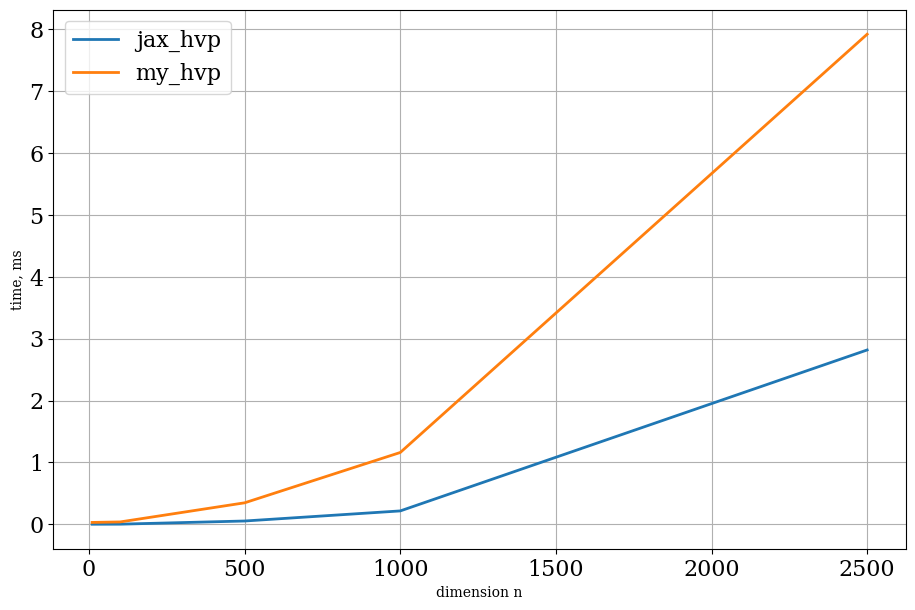

In [50]:
plt.plot(ns, jax_hvp_times, label="jax_hvp")
plt.plot(ns, my_hvp_times, label="my_hvp")
plt.xlabel("dimension n")
plt.ylabel("time, ms")
plt.grid()
plt.legend()
plt.show()

## Граф вычислений в библиотеке Pytorch

Из первой части семинара можно отметить, что мы чаще хотим вычислять градиент от вектор функции $f: \mathbb{R}^m \rightarrow \mathbb{R}^n,$ а не обычных функций. Да, с помощью *autograd* или *jax* мы уже можем вычислять такое, и даже с матрицами можем сделать что-то. 

Посмотрим, как библиотека *pytorch* позволяет вычислять данные величины!

Материал опирается по структуре на семинар МГУ по [курсу DL](https://github.com/nadiinchi/dl_labs/blob/master/lab_pytorch.ipynb). Там же более подробно разобраны возможности для написания кода для обучения нейронных сетей. Мы же рассмотрим только необходимые для решения задач оптимизации возможности.


### Основы pytorch

Пройдёмся по основам - на самом деле, *pytorch* очень напоминает *numpy*, но оперирует *тензорами* в качестве элементарной единицы операций:

In [6]:
x = np.arange(16).reshape(4, 4)
print('Тип x:', type(x))
x_torch = torch.arange(0, 16).view(4, 4).float()
print('Тип x_torch:', type(x_torch))


print("x:\n" +f"{x}")
print("x + 42:\n" +f"{x+42}")

print("x_torch:\n" +f"{x_torch}")
print("x_torch + 42:\n" +f"{x_torch+42}")

Тип x: <class 'numpy.ndarray'>
Тип x_torch: <class 'torch.Tensor'>
x:
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
x + 42:
[[42 43 44 45]
 [46 47 48 49]
 [50 51 52 53]
 [54 55 56 57]]
x_torch:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
x_torch + 42:
tensor([[42., 43., 44., 45.],
        [46., 47., 48., 49.],
        [50., 51., 52., 53.],
        [54., 55., 56., 57.]])


Отличия по операциям минимальны и легко находятся в [документации](https://pytorch.org/docs/stable/index.html) и google (Stackoverflow/tutorials):

```
x.reshape([1,2,8]) -> x.view(1,2,8)
x.sum(axis=-1) -> x.sum(dim=-1)
x.astype('int64') -> x.type(torch.LongTensor)
```
Можно преобразовать одно в другое 

```
torch.from_numpy(npx) -- returns Tensor
tt.numpy() -- returns Numpy Array
```

In [9]:
print("x*x^T:\n" +f"{np.dot(x, x.T)}")
print("x_torch*x_torch^T:\n" + f"{torch.matmul(x_torch, x_torch.transpose(1, 0))}")
print()
print("Усредним вдоль колонок:\n" + f"{x.mean(axis=-1)}")
print("Усредним вдоль колонок tensor:\n" + f"{torch.mean(x_torch, dim=-1)}")
print()
print("Кумулятивная сумма колонок:\n" + f"{np.cumsum(x, axis=0)}")
print("Кумулятивная сумма колонок tensor:\n" + f"{torch.cumsum(x_torch, dim=0)}")

x*x^T:
[[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
x_torch*x_torch^T:
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])

Усредним вдоль колонок:
[ 1.5  5.5  9.5 13.5]
Усредним вдоль колонок tensor:
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])

Кумулятивная сумма колонок:
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]
Кумулятивная сумма колонок tensor:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


Также интерфейс *pytorch* позволяет создать тензор из *numpy*-массива и преобразовать типы:

In [10]:
y = torch.from_numpy(x)
print('Type of y:', type(y))
y = torch.from_numpy(x).type(torch.FloatTensor)
print('Type of y', type(y))

Type of y: <class 'torch.Tensor'>
Type of y <class 'torch.Tensor'>


#### In-place операции

Теперь мы работаем с тензорами, и ~~чаще всего~~ иногда они могут быть огромными.
Поэтому предусмотрена возможность *in-place* операций, что позволяет не создавать новый объект в памяти, а модифицировать существующий.
```
x.exp()   # not-in-place operation
x.exp_()  # in-place operation
```

In [11]:
x = torch.arange(4).float()
print('Not-in-place:')
print('\tx.exp():\t\t', x.exp().numpy())
print('\tx:\t\t\t', x.numpy())
print('In-place:')
print('\tx.exp_():\t\t', x.exp_().numpy())
print('\tx после x.exp_():\t', x.numpy())

Not-in-place:
	x.exp():		 [ 1.         2.7182817  7.389056  20.085537 ]
	x:			 [0. 1. 2. 3.]
In-place:
	x.exp_():		 [ 1.         2.7182817  7.389056  20.085537 ]
	x после x.exp_():	 [ 1.         2.7182817  7.389056  20.085537 ]


*In-place* операции позволяют уменьшать число выделяемых промежуточных тензоров в процессе вычисления:

In [55]:
x = torch.arange(0, 4).view(2, 2)
y = torch.arange(4, 8).view(2, 2)
z = torch.arange(8, 12).view(2, 2)

# Not-in-place:
u = x + 2 * y - z    # 3 array allocations?
print(u.numpy())

# In-place
u = y.clone()        # 1 array allocation
u.mul_(2)
u.add_(x)
u.sub_(z)
print(u.numpy())

[[0 2]
 [4 6]]
[[0 2]
 [4 6]]


#### Broadcasting в pytorch

Так же, как и в *numpy*, предусмотрен механизм расширения формы массивов для совмещения и выполнения операций на исходно разных (по размерностям) массивов. Подробнее в *pytorch* этот механизм описан в http://pytorch.org/docs/master/notes/broadcasting.html

In [56]:
a = torch.Tensor([1, 1, 1, 2]).view(4, 1)
b = torch.Tensor([1, 0, 1, 0]).view(1, 4)
c = torch.randn(16).view(4, 4)
print('a:', a)
print('b:', b)
print('a + b:', a + b)
print('c:', c)
print('b + c:', b + c)

a: tensor([[1.],
        [1.],
        [1.],
        [2.]])
b: tensor([[1., 0., 1., 0.]])
a + b: tensor([[2., 1., 2., 1.],
        [2., 1., 2., 1.],
        [2., 1., 2., 1.],
        [3., 2., 3., 2.]])
c: tensor([[-1.0979, -0.1398,  0.0521, -0.2555],
        [-0.6260,  1.2511, -1.0152,  1.9161],
        [ 0.7917,  1.2118, -1.1456,  0.2223],
        [ 0.2881, -0.7989, -0.1324,  1.3591]])
b + c: tensor([[-0.0979, -0.1398,  1.0521, -0.2555],
        [ 0.3740,  1.2511, -0.0152,  1.9161],
        [ 1.7917,  1.2118, -0.1456,  0.2223],
        [ 1.2881, -0.7989,  0.8676,  1.3591]])


### Построение графа вычислений

А теперь поговорим о том, для чего мы тут и собрались)

Концептуально, autograd хранит запись данных (тензоров) и всех выполненных операций (вместе с результирующими новыми тензорами) в ориентированном ациклическом графе (DAG), состоящем из объектов Function_.
В этом DAG *листья* -  входные тензора, *корни* - выходные. Благодаря полному пути от листьев к корням можно вычислить по chain-rule требуемые градиенты.

При **forward** проходе autograd делает две вещи одновременно:

- выполняет запрошенную операцию для вычисления результата в тензор
- поддерживает функцию градиента операции в DAG.

**Backward** проход начинается, когда функция *.backward()* вызывается в корне DAG. тогда autograd:

- вычисляет градиенты из каждого .grad_fn,
- накапливает их в атрибуте .grad соответствующего тензора
- используя chain rule, распространяется вплоть до конечных тензоров.

Давайте построим данный граф вычислений:

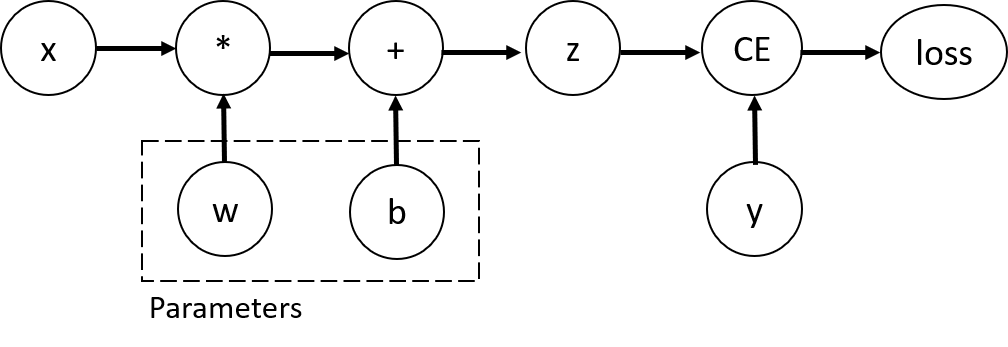

Для начала формирования графа вычислений необходимо указать входные переменные флагом ```requires_grad```:

In [18]:
x = torch.ones(5)  # входной тензор
y = torch.zeros(3)  # вектор выходных значений
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

Как и говорилось ранее, для каждого объекта Function сохраняется и grad_fn при *backpropagation*.

Для более сложных примеров chain-rule на графе вычислений можно посмотреть [CSC321](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec06.pdf)

In [19]:
print(f"Функция градиента для z = {z.grad_fn}")
print(f"Функция градиента для loss = {loss.grad_fn}")

Функция градиента для z = <AddBackward0 object at 0x000002C2D33722C8>
Функция градиента для loss = <BinaryCrossEntropyWithLogitsBackward object at 0x000002C2D3372888>


**Для того, чтобы вычислить градиенты вызывается .backward() проход от корня со скалярным выходом**

In [20]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1898, 0.0126, 0.2743],
        [0.1898, 0.0126, 0.2743],
        [0.1898, 0.0126, 0.2743],
        [0.1898, 0.0126, 0.2743],
        [0.1898, 0.0126, 0.2743]])
tensor([0.1898, 0.0126, 0.2743])


По умолчанию, все переменные с ``requires_grad=True`` отслеживаются для вычисления градиента в дальнейшем. Чтобы перестать отслеживать выполняемые с ними операции можно использовать режим ``.no_grad()``

In [21]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Также можно применить метод ``detach()`` к тензору

In [22]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


Это может потребоваться при:
  - Обучении нейронных сетей, чтобы заморозить часть параметров.
  - Оптимизации скорости вычисления. Поскольку для этих переменных будет осуществляться только *forward*

Также **важно запомнить**, что граф накапливает градиенты при вызове *backward()*. Поэтому важно не забывать об этом при оптимизации.

### Примеры функций и вектор-функций

В случае с вектор-функциями, pytorch использует **Jacobian product**, а не вычисляет градиент.

Для вектор-функции $\vec{y}=f(\vec{x})$, где
$\vec{x}=\langle x_1,\dots,x_n\rangle$ и
$\vec{y}=\langle y_1,\dots,y_m\rangle$, производная
$\vec{y}$ по $\vec{x}$ задаётся матрицей Якоби:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

Вместо вычисления матрицы Якоби, pytorch вычисляет **Jacobian Product** $v^T\cdot J$ для заданного входного вектора $v=(v_1 \dots v_m)$. Для этого подаём в ``backward`` аргумент. Размер аргумента должен быть равен размеру тензора, по которому берём производную

In [24]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"Первый вызов \n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nВторой вызов \n{inp.grad}")

inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nВызов после обнуления градиентов\n{inp.grad}")

Первый вызов 
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Второй вызов 
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Вызов после обнуления градиентов
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Кроме этого, для нелистовых переменных библиотека позволяет также сохранить градиенты с помощью ``retain_grad()``

In [25]:
x = torch.randn(4, requires_grad=True)   # листовые переменные
z = torch.randn(4, requires_grad=True)   # листовые переменные
w = z * 2      # не листовая переменная
y = x * w + 1  # прямой ход перед retain_grad выполним спокойно!
p = y.sum()

w.retain_grad()

p.backward()
print('dp / dx:', x.grad)
print('dp / dz:', z.grad)
print('dp / dw:', w.grad)

dp / dx: tensor([ 2.2866, -1.6330, -3.0333,  3.4309])
dp / dz: tensor([-1.6640,  2.3511, -2.2639,  3.3146])
dp / dw: tensor([-0.8320,  1.1756, -1.1320,  1.6573])


### Давайте что-нибудь пооптимизируем

Вам дана некоторая ~~странная~~ функция потери, которая заставляет линейное преобразование отображать точки 10-мерного пространства в 2-мерный круг с радиусом 1. Вы должны использовать градиентный спуск по параметрам преобразования.

Линейное преобразование 10-мерной точки $x$ в 2-мерную точку $y$ имеет веса $W$ и $b$ и выглядит следующим образом:
$$y = Wx + b$$

Норма двумерного пространства Евклидова:
$$||y||_2 = \sqrt{y_1^2 + y_2^2}$$

Лосс функция $f_0$ штрафует точку $y$ за отдаление от окружности радиуса 1:
$$f_0(x, W, b) = 0.5 \cdot \big| ||y||_2 - 1 \big| + \big( ||y||_2 - 1 \big)^2$$

К сожалению, оптимизация по $f_0$ по $W$ и $b$ может быть осуществлена аналитически и выдаёт $W = 0$, $b = (1, 0)$.
Чтобы избежать такого решения, мы также наказываем за близость $y$ к $b$. Этот штраф обращается в $0$ если расстояние от $y$ до $b$ больше $1$:
$$f_1(x, W, b) = \max\big(0, \frac{1}{||y - b||_2} - 1\big)$$

Итоговая loss-функция выглядит следующим образом:
$$f(x, W, b) = f_0(x, W, b) + f_1(x, W, b)$$

Вам требуется решить следующую задачу оптимизации:
$$\frac{1}{N}\sum\limits_{i = 1}^N f(x_i, W, b) \to \min\limits_{W, b}$$

In [88]:
X = torch.randn(50, 10)
b = torch.randn(2)
W = torch.randn(10, 2)

In [89]:
def f(X, W, b):
    ### your code here ###

In [90]:
print(f(X, W, b))

tensor(15.0581)


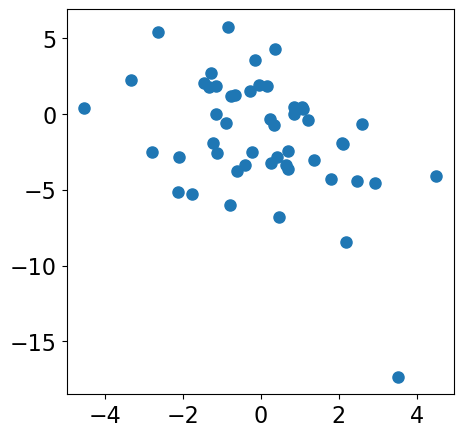

In [91]:
plt.figure(figsize=(5, 5))
Y = X.mm(W).add(b)
plt.scatter(Y[:, 0], Y[:, 1]);

In [92]:
### your code here ###

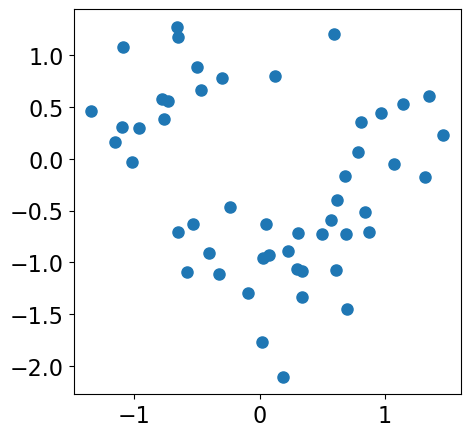

In [95]:
plt.figure(figsize=(5, 5))
Y = X.mm(W.detach()).add(b.detach())
plt.scatter(Y[:, 0], Y[:, 1]);

#### Блок заданий на интерес

1. (Задание на интерес) Реализуйте (найдите простенькую реализацию) полносвязной нейронки. Поиграйтесь с optimisers Можно ли сделать кружочек идеальным? 

2. Решите пазл с помощью pytorch. (Найдено [здесь](https://machinelearningmastery.com/using-autograd-in-pytorch-to-solve-a-regression-problem/))
```
[ A ]  +  [ B ]  =  9
  +         -
[ C ]  -  [ D ]  =  1
  =         =
  8         2
```

### Напоследок. Как достать матрицы Гессе и Якоби?

Pytorch, кроме вычисления Jacobian product, позволяет и напрямую доставать матрицу Якоби и Гессе.

Рассмотрим на простой функции, как это сделать:

In [73]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.0091]), tensor([0.4140]))


(tensor([[2.0182]]), tensor([[3.]]))

Первый выход должен быть равен $2e^x$, а второй -  3.

**Естественно, это можно проделать и с тензорами большего порядка**

In [74]:
inputs = (torch.rand(3), torch.rand(3)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.3875, 0.3072, 0.6598]), tensor([0.2269, 0.3239, 0.9223]))


(tensor([[2.9465, 0.0000, 0.0000],
         [0.0000, 2.7193, 0.0000],
         [0.0000, 0.0000, 3.8687]]),
 tensor([[3., 0., 0.],
         [0., 3., 0.],
         [0., 0., 3.]]))

Метод ``torch.autograd.functional.hessian()`` для дважды дифференцируемой функции работает аналогично (вычисляя матрицу Гессе). Только функция должна возвращать одно число...

In [75]:
def pow_adder_reducer(x, y):
    return (2 * x.pow(2) + 3 * y.pow(2)).sum()

inputs = (torch.rand(2), torch.rand(2))
torch.autograd.functional.hessian(pow_adder_reducer, inputs)

((tensor([[4., 0.],
          [0., 4.]]),
  tensor([[0., 0.],
          [0., 0.]])),
 (tensor([[0., 0.],
          [0., 0.]]),
  tensor([[6., 0.],
          [0., 6.]])))

Также можно напрямую вычислять произведение Якоби ($j$) на вектор ($v$) - vjp\jvp

In [76]:
def do_some_doubling(x):
    y = x * 2
    while y.data.norm() < 1000:
        y = y * 2
    return y

inputs = torch.randn(3)
my_gradients = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, v=my_gradients)

(tensor([1158.5569, -354.3551, -534.6226]),
 tensor([5.1200e+01, 5.1200e+02, 5.1200e-02]))

Методы``vhp()`` и  ``hvp()`` считают произведения уже с матрицей Гессе.

Подробнее, можно посмотреть [документацию](https://pytorch.org/docs/stable/autograd.html#functional-higher-level-api)_


